# Homework 4

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

# Group B

***

In [33]:
import numpy as np
import pandas as pd

import platform
if platform.system() == "Windows":
    BASE_DIR = r'C:\Users\Alex\Desktop\Academic\UChicago\FINM 37500\finm-fiderivs-2024'
else:
    BASE_DIR = r'/Users/alexhuang/Documents/Academic/FINM 37500/finm-fiderivs-2024'


import sys, os
sys.path.append(BASE_DIR)

from cmds.binomial import *
from cmds.ratecurves import *
from cmds.volskew import *
from cmds.ficcvol import *
from cmds.fi_binomial_model import FIBinomialModel

In [34]:
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

# Data

### Note
This homework continues with the data from `Homework 3`.

### Swaption Vol Data

The file `data/swaption_vol_data_2024-02-20.xlsx` has market data on the implied volatility skews for swaptions. Note that it has several columns:
* `expry`: expiration of the swaption
* `tenor`: tenor of the underlying swap
* `model`: the model by which the volatility is quoted. (All are Black.)
* `-200`, `-100`, etc.: The strike listed as difference from ATM strike (bps). Note that ATM is considered to be the **forward swap rate** which you can calculate.

Your data: ywill use a single row of this data for the `1x4` swaption.
* date: `2024-02-20`
* expiration: 1yr
* tenor: 4yrs

As in `Homework 3`, you will need the forward swap value and the actual strikes being referred to in the provided data (which quotes relative strikes.)

# 1. SABR Volatility Modeling

Use the quoted volatility skew to fit a SABR model.
* Throughout, parameterize, `beta=.75`.

In [35]:
BETA = 0.75
swaption_vol_df = pd.read_excel(r'../data/swaption_vol_data.xlsx')
swaption_vol_df

,reference,instrument,model,date,expiration,tenor,-200,-100,-50,-25,0,25,50,100,200
0,SOFR,swaption,black,2024-02-20,1,4,54.54,40.37,35.94,34.23,32.83,31.71,30.86,29.83,29.54


In [53]:
curves = pd.read_excel(r'../data/cap_curves_2024-02-20.xlsx', index_col=0)
curves

,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
tenor,,,,,,
0.25,0.052211,0.052211,0.987115,NaN,NaN,NaN
0.50,0.051540,0.051535,0.974722,0.050860,0.166025,0.166025
0.75,0.050506,0.050490,0.963069,0.048400,0.191290,0.210648
1.00,0.049284,0.049250,0.952230,0.045531,0.216554,0.254312
1.25,0.047631,0.047565,0.942608,0.040831,0.260043,0.361247
1.50,0.046235,0.046141,0.933499,0.039030,0.292615,0.380930
1.75,0.045059,0.044939,0.924774,0.037738,0.315878,0.388953
2.00,0.044133,0.043994,0.916212,0.037382,0.331443,0.386643
2.25,0.043173,0.043011,0.908230,0.035151,0.340919,0.376247


In [54]:
DATE = '2023-05-01'
freqcurve = 4

SWAP_TYPE = 'SOFR'
QUOTE_STYLE = 'black'
RELATIVE_STRIKE = 0

expry = 1
tenor = 4

freqswap = 4
isPayer=True
N = 100

In [57]:
Topt = expry
Tswap = Topt+tenor

fwdrate = curves['forwards'][Topt]

fwdswap = calc_fwdswaprate(curves['discounts'], Topt, Tswap, freqswap=freqswap)
BETA = 0.75
strikerange = swaption_vol_df.columns[-9:]
F = fwdswap - 1e-8

In [58]:
vols = swaption_vol_df[strikerange].iloc[0]
vols /= 100
strikes = fwdswap + strikerange/100/100

In [84]:

period_fwd = curves.index.get_loc(Topt)
period_swap = curves.index.get_loc(Tswap)+1

discount = curves['discounts'].iloc[period_fwd+1: period_swap].sum() / 4
discount

3.524129268625859

In [60]:
def obj_fun(xargs):
    nu = xargs[0]
    rho = xargs[1]
    alpha = xargs[2]
    
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr(BETA,nu,rho,alpha,F,strike,Topt)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error

In [95]:
idstrikeATM = np.where(np.array(strikerange, dtype=int)==0)[0][0]
volATM = vols.loc[0]

def obj_fun_slim(xargs):
    nu = xargs[0]
    rho = xargs[1]
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr_slim(BETA,nu,rho,F,strike,Topt,volATM)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error

## 1.1
Estimate $(\alpha,\rho,\nu)$ via the SABR formula. Feel free to use the `sabr` function in `cmds/volskew.py`.

Report the values of these parameters.

In [69]:
x0 = np.array([0.6, 0, 0.1])
optim = minimize(obj_fun, x0)
xstar = optim.x
error = optim.fun
xstar

array([ 0.77690053, -0.42604806,  0.14110701])

In [75]:
param = pd.DataFrame([BETA,xstar[0],xstar[1],xstar[2],error],index=['beta','nu','rho','alpha','fit error'],columns=['SABR Parameters'])
param.style.format('{:.4f}')

,SABR Parameters
beta,0.7500
nu,0.7769
rho,-0.4260
alpha,0.1411
fit error,0.0001


## 1.2
Create a grid of strikes of `[.0025, .09]`, with grid spacing of `10bps`, (.0010).

Use the SABR model parameterized above to calculate the volatility for each of these strikes.

* Plot the SABR curve, and also include the market quotes in the plot.

* Conceptually, does the SABR curve fit these points well? Perfectly?

In [76]:
nustar = param.iloc[1,0]
alphastar = param.iloc[3,0]
rhostar = param.iloc[2,0]

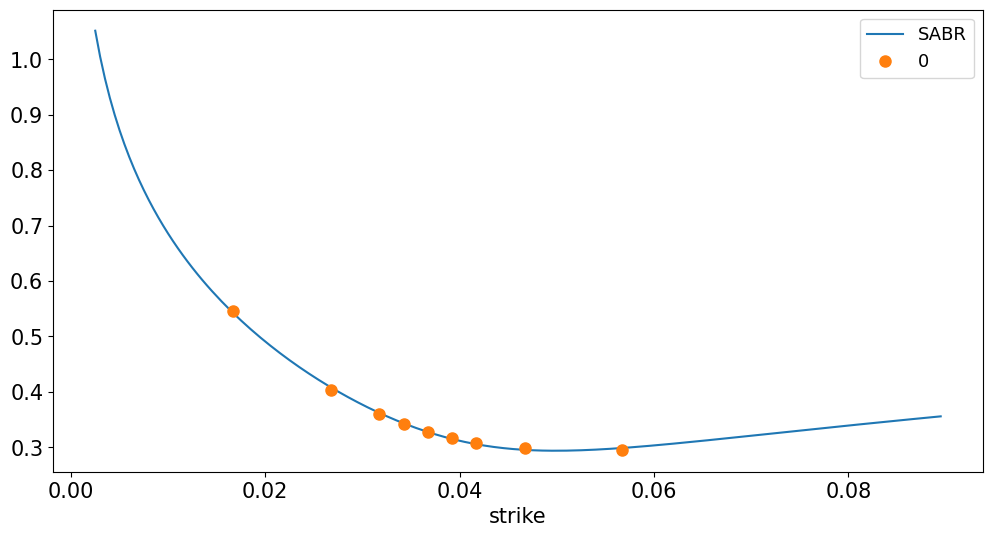

In [83]:
strikegrid = np.arange(.0025,.09,.0005)

ivolgrid = sabr(BETA,nustar,rhostar,alphastar,F,strikegrid,Topt)
    
sabrcurve = pd.DataFrame(ivolgrid,index=strikegrid,columns=['SABR'])

volquotes = swaption_vol_df.copy()[strikerange]
# volquotes
volquotes.loc['strike'] = strikes
volquotes = volquotes.T.set_index('strike').rename(columns={'implied vol':'market quotes'}) / 100

# display(volquotes)
# display(sabrcurve)
fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)
volquotes.plot(linestyle='',marker='o',markersize=8,ax=ax)
plt.legend();

Yes, it does fit the curve well.

## 1.3
Suppose we want to price the `1y4y` swaption but with a far out-of-the-money strike of `5%`. 

* Use the SABR vol at this strike to price the swaption.

(Note that this strike is far outside the range for which we have market quotes, and even if we do have quotes, they likely are not liquid on a given day.)



In [86]:
NEWSTRIKE = .05

newvol = sabr(BETA,nustar,rhostar,alphastar,F,NEWSTRIKE,Topt)

newprice = N * blacks_formula(Topt,newvol,NEWSTRIKE,fwdswap,discount,isCall=isPayer)
display(f'Price of the OTM swaption at strike {NEWSTRIKE:.2%} is ${newprice:.4f}.')

'Price of the OTM swaption at strike 5.00% is $0.3336.'

## 1.4

Use the ATM implied volatility to fit $\alpha$, (sometimes denoted $\sigma_0$.) That is, for any choice of $(\rho,\nu)$, solve a quadratic equation to get $\alpha$ as a function of those two parameters, along with $\beta$, which is at its selected (not estimated) value.

Recall that we have a simple relationship between ATM vol and $\alpha$.
$$\sigma_\text{ATM} = \alpha\frac{B}{F^{1-\beta}}$$
where $B$ is defined in the discussion note. It is a quadratic expression of $\alpha$ along with $(\beta,\rho,\nu)$.

This decouples the optimization. We solve for $(\rho,\nu)$ and $\alpha$ as a function of the other two parameters.

Consider using the function `sabrATM` in `cmds/volskew.py`.

In [99]:
optim = minimize(obj_fun_slim,x0)
xstar_slim = optim.x
nustar_slim = xstar_slim[0]
rhostar_slim = xstar_slim[1]
alphastar_s = solve_alpha(BETA,nustar_slim,rhostar_slim,Topt,volATM,F)

In [100]:
pd.DataFrame([BETA,nustar_slim,rhostar_slim,alphastar_s],index=['beta','nu','rho','alpha'],columns=['SABR Parameters SLIM'])

,SABR Parameters SLIM
beta,0.750000
nu,0.773283
rho,-0.428070
alpha,0.141402


***

# 2. SABR and Risk Management

Consider how an **increase** of `50bps` in the underlying rate impacts the price of the `1y4y` ATM swaption.

Here, we are assuming that
* the rate change will impact the forward swap rate directly, one-for-one with other rates.
* the shift happens on `Feb 21, 2024`.

Of course, in reality, a rate change
* may price in early to some degree if it is expected
* may not impact the forward swap rate one-for-one. We would need to model how the discount curve changes and what that change (level, slope, curvature?) would do to the forward swap rate.

## 2.1

Use Black's equation to re-price the `1y4y` swaption with
* the same ATM volatility
* an underlying (forward swap) rate increased `50bps`.
* the same time-to-maturities. (We should decrease these all by 1/365, but we focus here on the delta effects rather than the theta. And it would be a small impact anyone.)

Report 
* the new price
* the change in price divided by `50bps`, (a numerical delta.)

In [104]:
SHIFT = 0.005
DATE = '2024-02-21'
Frange = F + [0, SHIFT]

sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'] = sabr(BETA,nustar,rhostar,alphastar,F+SHIFT,strikegrid,Topt)

newvols = sabrcurve.loc[(sabrcurve.index.to_series()-fwdswap).abs().idxmin()]

blackprices = pd.Series(N * blacks_formula(Topt-np.array([0,1/365]), newvols[0], strikes[idstrikeATM],Frange,discount,isCall=isPayer), index=[DATE,'shift'], name='static').to_frame().T
blackprices

C:\Users\Alex\AppData\Local\Temp\ipykernel_88184\864116051.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  blackprices = pd.Series(N * blacks_formula(Topt-np.array([0,1/365]), newvols[0],strikeATM,Frange,discount,isCall=isPayer), index=[DATE,'shift'], name='static').to_frame().T


,2024-02-21,shift
static,1.691214,2.817924


In [113]:
delta = (blackprices.diff(axis=1) / SHIFT)['shift'].rename('delta')
delta.to_frame().style.format('{:.2f}')

,delta
static,225.34
dynamic,245.34


## 2.2

Now, we consider how the volatility may change with the underlying shift of `50bps`.

Using the same SABR parameters from `1.1`, and the strike grid from `1.2`, plot the new SABR curve accounting for the underlying rate shifting up `50bps`.

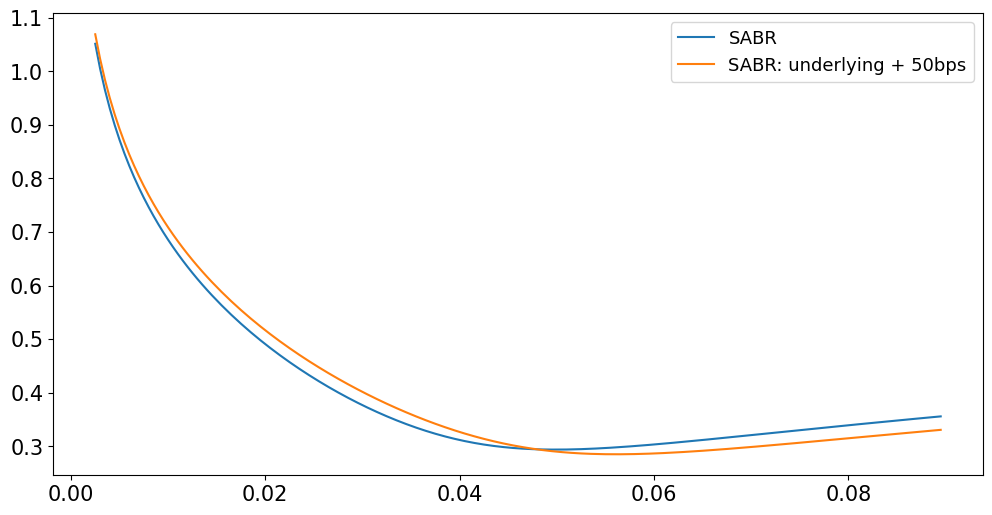

In [105]:
sabrcurve.plot()
plt.show()

## 2.3

Calculate the new volatility specifically for the pre-shift ATM strike.

Use this in Black's formula similar to `2.1`, where the only change is the volatility now reflects the shift in the underlying (not the strike).

Report
* the new price
* the change in price divided by `50bps`

In [106]:
blackprices.loc['dynamic'] = 100 * blacks_formula(Topt-np.array([0,1/365]), newvols,strikes[idstrikeATM],Frange,discount,isCall=True)
blackprices

,2024-02-21,shift
static,1.691214,2.817924
dynamic,1.691214,2.917896


In [107]:
delta = (blackprices.diff(axis=1) / SHIFT)['shift'].rename('delta')
delta = pd.DataFrame(delta)
delta

,delta
static,225.341982
dynamic,245.336324


## 2.4

How much different is the (dynamic) delta which accounts for the shift in volatility from the (static) delta in `2.1`?

In [115]:
delta_relative_change = delta.pct_change().loc['dynamic']
display(f'Relative change to delta: {delta_relative_change:.2%}.')

'Relative change to delta: 8.87%.'

***